# M1 - Data Preparation and Preprocessing

**Curso:** Machine Learning M1  
**Ano letivo:** 2024/2025  
**Autores:** Francisco Nunes / Daniel Rodrigues — 2022147843 / 2022103368  
**Data:** Dezembro 2024

## Objetivos

Este notebook apresenta a preparação e preprocessamento de dados para o assignment M1 de Machine Learning.

O objetivo é preparar um dataset de classificação binária com:
- 70.000 registos de pacientes
- 14 features (numéricas, categóricas e ordinais)
- Target binário balanceado (50/50)
- Pipeline reprodutível com scikit-learn

## Estrutura do Notebook

1. **Importação e Visão Geral dos Dados**
2. **Análise Exploratória (EDA)**
3. **Limpeza e Tratamento de Valores em Falta**
4. **Feature Engineering**
   - Cálculo de BMI
   - Pulse Pressure e MAP
   - Grupos etários e categorias BMI
5. **Codificação de Features**
   - Numéricas: RobustScaler
   - Binárias: Sem transformação
   - Categóricas: One-hot encoding
   - Ordinais: Ordinal encoding
6. **Pipeline de Preprocessamento**
7. **Train/Test Split e Exportação**
8. **Validação Final**

## Dataset: Cardiovascular Disease

- **Fonte:** Kaggle - Cardiovascular Disease Dataset
- **Registos:** 70.000 pacientes
- **Features:** Idade, pressão arterial, colesterol, glucose, etc.
- **Target:** Presença de doença cardiovascular (0/1)
- **Balanceamento:** Perfeito (50% cada classe)

In [21]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Caminhos e dataset ---
PROC_PATH = Path("../data/processed")
RAW_PATH = Path("../data/raw")
DATASET = PROC_PATH / "cardio_clean.parquet"

assert DATASET.exists(), "Falta o processed. Corre primeiro: python main.py preprocess"

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
df = pd.read_parquet(DATASET)

if "id" in df.columns:
    df = df.drop(columns=["id"])

print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")

TARGET = "cardio"
assert TARGET in df.columns, f"Coluna alvo '{TARGET}' não encontrada!"
CAT_ORD_COLS = [c for c in ["cholesterol", "gluc"] if c in df.columns]
CAND_NOM = ["gender", "smoke", "alco", "active"]
CAT_NOM_COLS = [c for c in CAND_NOM if c in df.columns]

NUM_COLS = df.select_dtypes(include=[np.number]).columns.drop(TARGET).tolist()

assert len(NUM_COLS) > 0, "Sem colunas numéricas (excluindo o target)."
for c in CAT_ORD_COLS + CAT_NOM_COLS:
    assert c in df.columns, f"Coluna esperada '{c}' não existe no dataframe!"
    
df.head()


✅ Loaded: 70,000 rows × 13 cols


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,cardio
0,2,168,62.0,110,80,1,1,0,0,1,50.4,21.97,0
1,1,156,85.0,140,90,3,1,0,0,1,55.4,34.93,1
2,1,165,64.0,130,70,3,1,0,0,0,51.6,23.51,1
3,2,169,82.0,150,100,1,1,0,0,1,48.2,28.71,1
4,1,156,56.0,100,60,1,1,0,0,0,47.8,23.01,0


In [ ]:
print("\n--- Info ---")

df.info(memory_usage="deep")

print("\n--- Shape & dtypes ---")
print(f"rows: {len(df):,} | cols: {df.shape[1]}")
print("dtypes count:")
print(df.dtypes.value_counts())

print("\n--- Missing values (count & %) ---")
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_tbl = (
    pd.DataFrame({"missing": missing, "missing_%": missing_pct})
    .sort_values("missing", ascending=False)
)
display(missing_tbl[missing_tbl["missing"] > 0])
print(f"Total colunas com missing: {(missing > 0).sum()}")

num_only = df[NUM_COLS].select_dtypes(include=[np.number]).columns.tolist()
if num_only:
    desc_num = df[num_only].describe().T  
    keep = [c for c in ["mean", "std", "min", "max"] if c in desc_num.columns]
    display(desc_num[keep].round(3))
else:
    print("Nenhuma coluna numérica encontrada em NUM_COLS para sumarizar.")

CAT_COLS = (CAT_ORD_COLS + CAT_NOM_COLS)
if len(CAT_COLS) > 0:
    print("\n--- Resumo categóricas (n_unique) ---")
    display(pd.DataFrame({"n_unique": df[CAT_COLS].nunique().sort_values(ascending=False)}))




--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       70000 non-null  int64  
 1   height       70000 non-null  int64  
 2   weight       70000 non-null  float64
 3   ap_hi        70000 non-null  int64  
 4   ap_lo        70000 non-null  int64  
 5   cholesterol  70000 non-null  int64  
 6   gluc         70000 non-null  int64  
 7   smoke        70000 non-null  int64  
 8   alco         70000 non-null  int64  
 9   active       70000 non-null  int64  
 10  age_years    70000 non-null  float64
 11  bmi          70000 non-null  float64
 12  cardio       70000 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 6.9 MB

--- Shape & dtypes ---
rows: 70,000 | cols: 13
dtypes count:
int64      10
float64     3
Name: count, dtype: int64

--- Missing values (count & %) ---


,missing,missing_%


Total colunas com missing: 0


,mean,std,min,max
gender,1.350,0.477,1.00,2.00
height,164.419,7.713,147.00,184.00
weight,74.118,13.796,48.00,117.00
ap_hi,126.867,16.836,90.00,180.00
ap_lo,93.795,106.196,60.00,1000.00
cholesterol,1.367,0.680,1.00,3.00
gluc,1.226,0.572,1.00,3.00
smoke,0.088,0.283,0.00,1.00
alco,0.054,0.226,0.00,1.00
active,0.804,0.397,0.00,1.00



--- Resumo categóricas (n_unique) ---


,n_unique
cholesterol,3
gluc,3
gender,2
smoke,2
alco,2
active,2


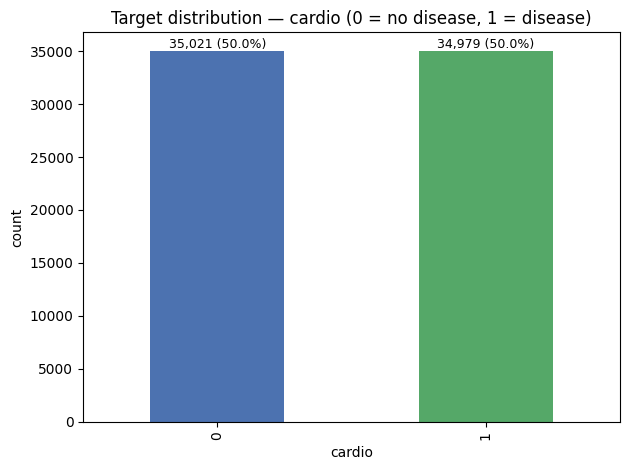

Proportion of positives: 0.500
Class ratio (neg:pos) = 1.00 : 1


In [ ]:
# --- Distribuição do target ---
ax = df[TARGET].value_counts().sort_index().plot(kind="bar", color=["#4c72b0", "#55a868"])
ax.set_title(f"Target distribution — {TARGET} (0 = no disease, 1 = disease)")
ax.set_xlabel(TARGET)
ax.set_ylabel("count")

tot = len(df)
for p in ax.patches:
    v = int(p.get_height())
    pct = v / tot * 100
    ax.annotate(f"{v:,} ({pct:.1f}%)",
                (p.get_x() + p.get_width() / 2, v),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

pos_rate = df[TARGET].mean()
neg_rate = 1 - pos_rate
print(f"Proportion of positives: {pos_rate:.3f}")
print(f"Class ratio (neg:pos) = {neg_rate/pos_rate:.2f} : 1")


In [27]:
assert TARGET == "cardio", "TARGET inesperado — confirma a célula 1."

NUM_COLS = df.select_dtypes(include=[np.number]).columns.drop(TARGET).tolist()

CAT_ORD_COLS = [c for c in ["cholesterol", "gluc"] if c in df.columns]

CAT_NOM_COLS = [c for c in ["gender", "smoke", "alco", "active"] if c in df.columns]

for c in CAT_ORD_COLS:
    df[c] = pd.Categorical(df[c], categories=[1, 2, 3], ordered=True)

for c in CAT_NOM_COLS:
    df[c] = df[c].astype("category")

NUM_COLS = [c for c in NUM_COLS if c not in CAT_ORD_COLS + CAT_NOM_COLS]

print("TARGET:", TARGET)
print("Numeric:", NUM_COLS)
print("Categorical (ordinal):", CAT_ORD_COLS)
print("Categorical (nominal):", CAT_NOM_COLS)

# Checks úteis
assert all(c in df.columns for c in NUM_COLS), "Alguma numérica não está no DF."
for c in CAT_ORD_COLS:
    assert set(df[c].dropna().unique()).issubset({1,2,3}), f"{c} tem valores fora de {1,2,3}."


TARGET: cardio
Numeric: ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
Categorical (ordinal): ['cholesterol', 'gluc']
Categorical (nominal): ['gender', 'smoke', 'alco', 'active']


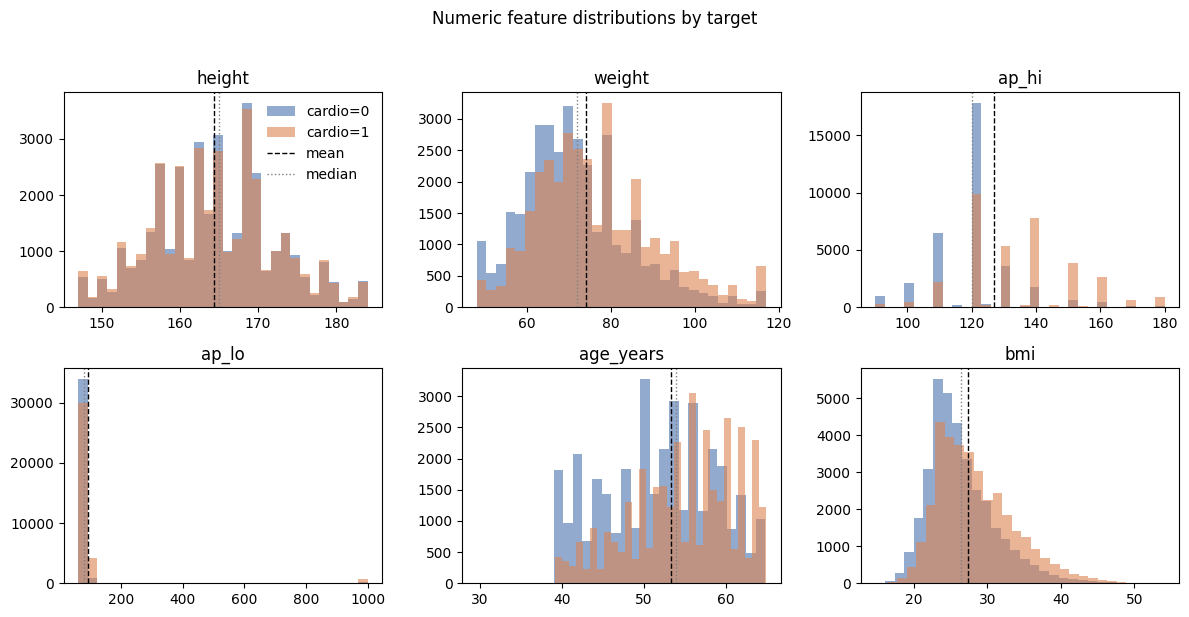

,mean,std,min,max,skew
height,164.42,7.71,147.00,184.00,0.11
weight,74.12,13.80,48.00,117.00,0.72
ap_hi,126.87,16.84,90.00,180.00,0.75
ap_lo,93.79,106.20,60.00,1000.00,8.31
age_years,53.30,6.76,29.60,64.90,-0.31
bmi,27.45,5.04,14.77,54.14,1.00


In [28]:
n = len(NUM_COLS)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes = axes.ravel()

for i, c in enumerate(NUM_COLS):
    for label, color in zip(sorted(df[TARGET].unique()), ["#4c72b0", "#dd8452"]):
        subset = df[df[TARGET] == label][c]
        axes[i].hist(subset, bins=30, alpha=0.6, label=f"{TARGET}={label}", color=color)
    axes[i].set_title(c)
    axes[i].axvline(df[c].mean(), color="k", linestyle="--", lw=1, label="mean" if i == 0 else "")
    axes[i].axvline(df[c].median(), color="grey", linestyle=":", lw=1, label="median" if i == 0 else "")
    axes[i].grid(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Numeric feature distributions by target", y=1.02)
axes[0].legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

desc = df[NUM_COLS].agg(["mean", "std", "min", "max", "skew"]).T.round(2)
display(desc)



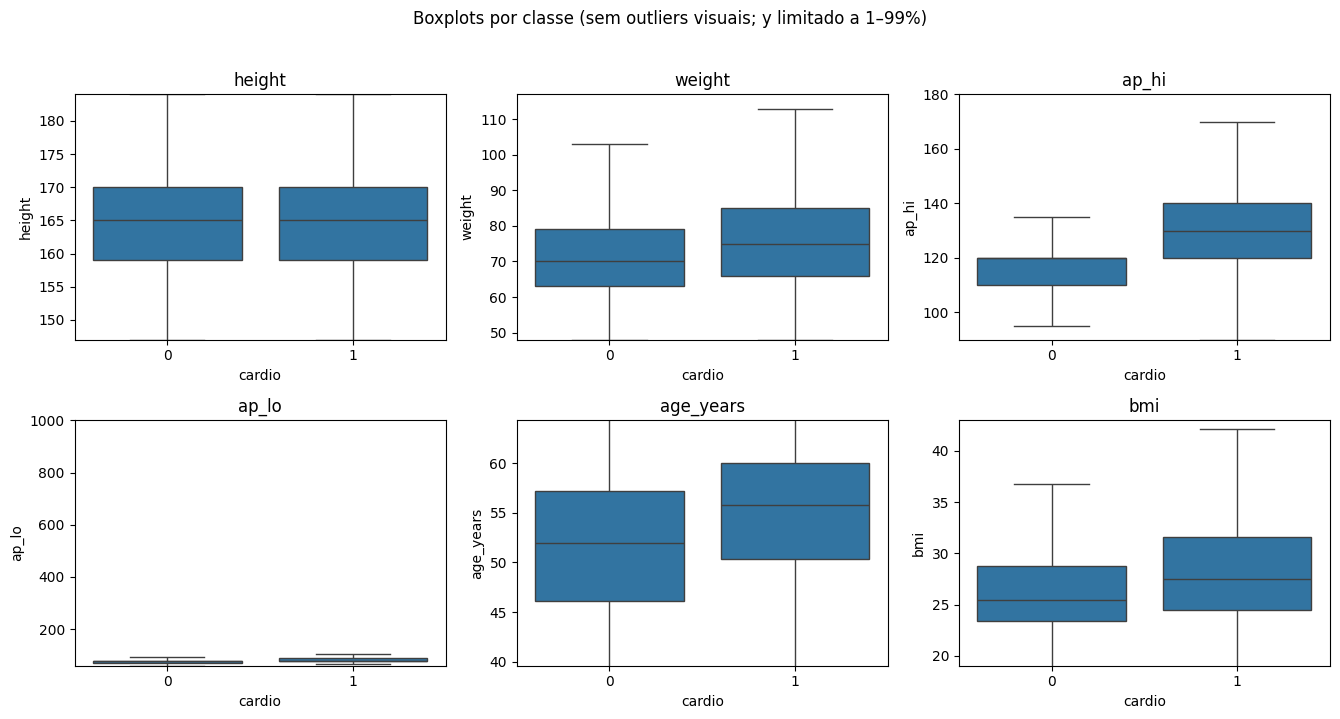

,feature,out_total_%,out_0_%,out_1_%
3,ap_lo,6.62,7.10,6.14
5,bmi,2.68,1.61,3.75
1,weight,2.52,1.51,3.54
2,ap_hi,1.59,0.45,2.73
4,age_years,0.01,0.01,0.00
0,height,0.00,0.00,0.00


In [29]:
order = sorted(df[TARGET].unique())
n = len(NUM_COLS)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 3.5))
axes = axes.ravel()

out_rows = []  

for i, c in enumerate(NUM_COLS):
    q01, q99 = df[c].quantile([0.01, 0.99])
    ax = axes[i]
    sns.boxplot(data=df, x=TARGET, y=c, order=order, showfliers=False, ax=ax)
    ax.set_title(c)
    ax.set_ylim(q01, q99)

    q1, q3 = df[c].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask_out = (df[c] < low) | (df[c] > high)
    out_total = mask_out.mean() * 100

    cls_stats = {}
    for cls in order:
        m = mask_out & (df[TARGET] == cls)
        denom = (df[TARGET] == cls).sum()
        cls_stats[f"out_{cls}_%"] = (m.sum() / denom * 100) if denom > 0 else 0.0

    out_rows.append({"feature": c, "out_total_%": round(out_total, 2), **{k: round(v, 2) for k, v in cls_stats.items()}})

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots por classe (sem outliers visuais; y limitado a 1–99%)", y=1.02)
plt.tight_layout()
plt.show()

out_tbl = pd.DataFrame(out_rows).sort_values("out_total_%", ascending=False)
display(out_tbl)

cardio,0,1
cholesterol,,
1,29330,23055
2,3799,5750
3,1892,6174


cardio,0,1
cholesterol,,
1,56.0%,44.0%
2,39.8%,60.2%
3,23.5%,76.5%


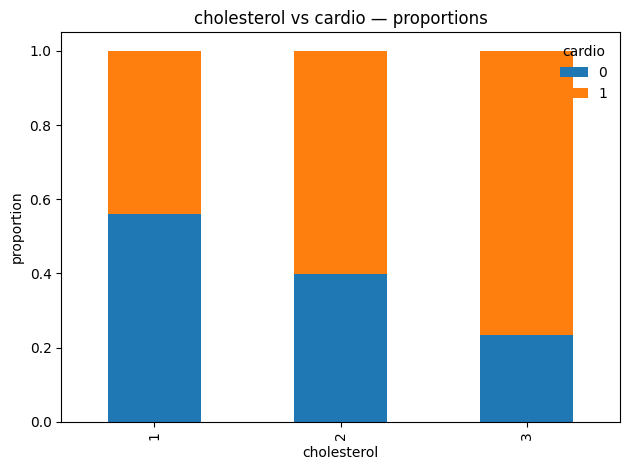

χ²(2) = 3423.44,  p-value = 0,  Cramer's V = 0.221


cardio,0,1
gluc,,
1,30894,28585
2,2112,3078
3,2015,3316


cardio,0,1
gluc,,
1,51.9%,48.1%
2,40.7%,59.3%
3,37.8%,62.2%


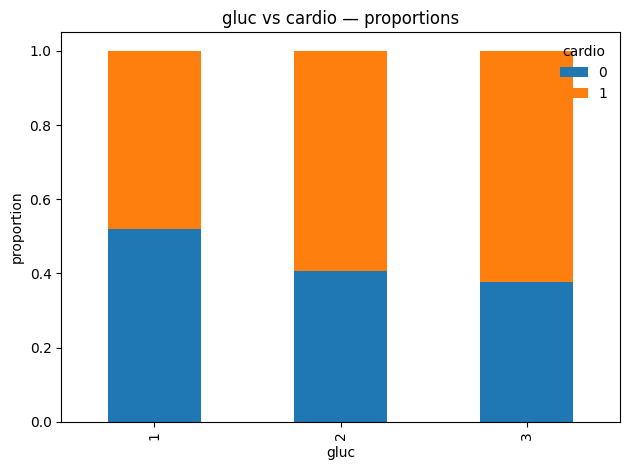

χ²(2) = 586.91,  p-value = 3.58e-128,  Cramer's V = 0.092


cardio,0,1
gender,,
1,22914,22616
2,12107,12363


cardio,0,1
gender,,
1,50.3%,49.7%
2,49.5%,50.5%


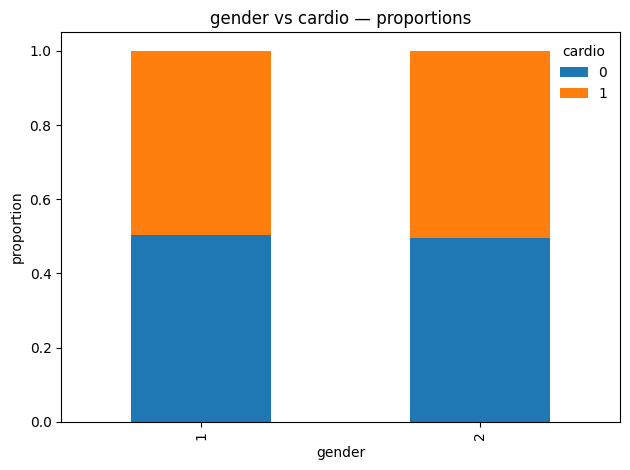

χ²(1) = 4.57,  p-value = 0.0325,  Cramer's V = 0.008


cardio,0,1
smoke,,
0,31781,32050
1,3240,2929


cardio,0,1
smoke,,
0,49.8%,50.2%
1,52.5%,47.5%


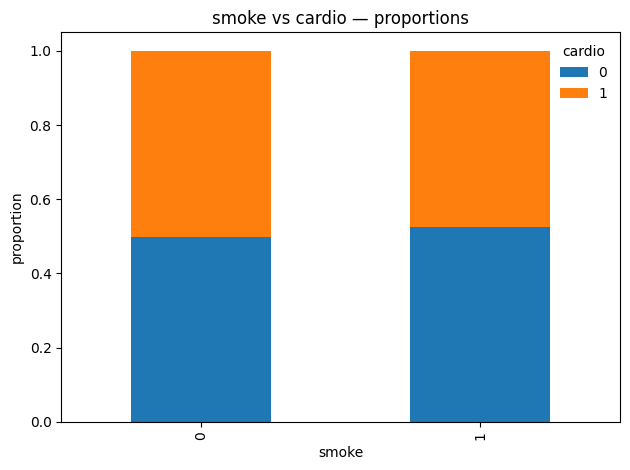

χ²(1) = 16.68,  p-value = 4.43e-05,  Cramer's V = 0.015


cardio,0,1
alco,,
0,33080,33156
1,1941,1823


cardio,0,1
alco,,
0,49.9%,50.1%
1,51.6%,48.4%


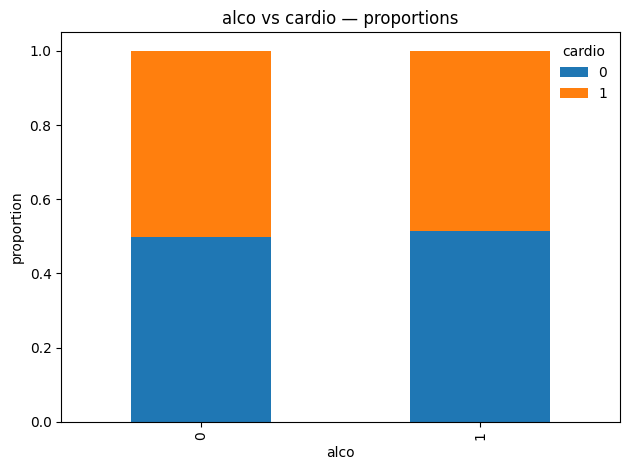

χ²(1) = 3.70,  p-value = 0.0545,  Cramer's V = 0.007


cardio,0,1
active,,
0,6378,7361
1,28643,27618


cardio,0,1
active,,
0,46.4%,53.6%
1,50.9%,49.1%


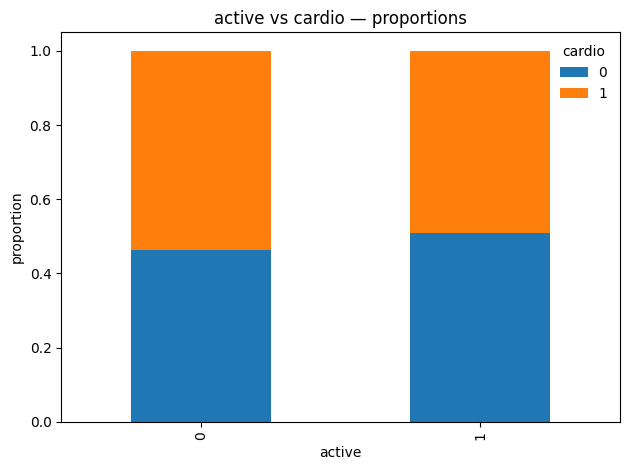

χ²(1) = 88.80,  p-value = 4.37e-21,  Cramer's V = 0.036


In [31]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

def cramers_v(confusion):
    chi2, _, _, _ = chi2_contingency(confusion)
    n = confusion.to_numpy().sum()
    r, k = confusion.shape
    v = np.sqrt((chi2 / n) / (min(r - 1, k - 1) if min(r - 1, k - 1) > 0 else 1))
    return v

def plot_categorical(cname, ordered=None):
    # ordered: lista opcional de categorias na ordem desejada (para ordinais)
    s = df[cname].copy()

    # garantir que é Series
    s = pd.Series(s, name=cname)

    # se tiver ordem explícita (ordinais)
    if ordered is not None:
        s = pd.Categorical(s, categories=ordered, ordered=True)
        s = pd.Series(s, name=cname)

    # incluir missing como categoria explícita
    s = s.astype("object")
    s = s.where(~s.isna(), "MISSING")

    # contingência (contagens) e proporções por linha
    ct_counts = pd.crosstab(s, df[TARGET])
    ct_props  = pd.crosstab(s, df[TARGET], normalize="index")

    # ordenar linhas para ordinais, se aplicável
    if ordered is not None:
        order_with_na = [*ordered, "MISSING"] if "MISSING" in ct_counts.index else ordered
        ct_counts = ct_counts.reindex(order_with_na)
        ct_props  = ct_props.reindex(order_with_na)

    # exibir tabelas
    display(ct_counts.style.set_caption(f"[counts] {cname} vs {TARGET}"))
    display((ct_props*100).round(1).style.format("{:.1f}%").set_caption(f"[proportions] {cname} vs {TARGET}"))

    # gráfico empilhado das proporções
    ax = ct_props.plot(kind="bar", stacked=True)
    ax.set_title(f"{cname} vs {TARGET} — proportions")
    ax.set_ylabel("proportion")
    ax.legend(title=TARGET, frameon=False)
    plt.tight_layout()
    plt.show()

    # teste χ² e Cramer's V
    try:
        chi2, p, dof, _ = chi2_contingency(ct_counts)
        v = cramers_v(ct_counts)
        print(f"χ²({dof}) = {chi2:.2f},  p-value = {p:.3g},  Cramer's V = {v:.3f}")
    except Exception as e:
        print(f"Não foi possível calcular χ²/Cramer's V para {cname}: {e}")
        
for c in CAT_ORD_COLS:
    if c in df.columns:
        plot_categorical(c, ordered=[1, 2, 3])

for c in CAT_NOM_COLS:
    if c in df.columns:
        plot_categorical(c, ordered=None)

O main.py já fez: renomeação de colunas, age_years, clipping p1–p99 (ap_hi, ap_lo, height, weight) e cálculo do BMI.
Aqui apenas validamos nulos e removemos colunas irrelevantes/IDs (não existem IDs neste dataset).

In [32]:
# --- Missing values: contagem, percentagem e plano de imputação ---
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
miss_tbl = pd.DataFrame({"missing": missing, "missing_%": missing_pct})

print("Colunas com missing (se vazio, não há missing):")
display(miss_tbl.query("missing > 0"))

n_cols_missing = int((missing > 0).sum())
print(f"\nTotal de colunas com missing: {n_cols_missing}")

# Visualização (top 15 com missing, se existirem)
if n_cols_missing > 0:
    top = miss_tbl.query("missing > 0").head(15)
    ax = top["missing_%"].plot(kind="barh")
    ax.set_title("Top missing (%)")
    ax.set_xlabel("missing %")
    plt.tight_layout(); plt.show()

# --- Plano de imputação proposto ---
# Regra: numéricos -> mediana; categóricas -> moda
impute_plan = {}
for c in df.columns:
    if c == TARGET:
        continue
    if c in NUM_COLS:
        impute_plan[c] = "median"
    elif c in (CAT_ORD_COLS + CAT_NOM_COLS):
        impute_plan[c] = "most_frequent"
    else:
        # fallback conservador
        impute_plan[c] = "most_frequent"

print("\nPlano de imputação (amostra de 10 colunas):")
sample_plan = dict(list(impute_plan.items())[:10])
for k, v in sample_plan.items():
    print(f" - {k}: {v}")

# Sanidade: dataset pós-preprocess costuma ter missing ~0
if n_cols_missing == 0:
    print("\n✅ Sem valores em falta — imputação ficará definida no pipeline por segurança.")
else:
    print("\n⚠️ Existem valores em falta — certifica-te que o pipeline aplica as estratégias acima.")


Colunas com missing (se vazio, não há missing):


,missing,missing_%



Total de colunas com missing: 0

Plano de imputação (amostra de 10 colunas):
 - gender: most_frequent
 - height: median
 - weight: median
 - ap_hi: median
 - ap_lo: median
 - cholesterol: most_frequent
 - gluc: most_frequent
 - smoke: most_frequent
 - alco: most_frequent
 - active: most_frequent

✅ Sem valores em falta — imputação ficará definida no pipeline por segurança.


Vamos enriquecer com features úteis e marcar adequadamente ordinais:

Pulse Pressure: pp = ap_hi - ap_lo

Mean Arterial Pressure (MAP): map = ap_lo + (ap_hi - ap_lo)/3

BMI categories (WHO)

Age groups

Ordinais: cholesterol, gluc (valores 1–3 com ordem)

In [33]:
# --- Engenharia de features numéricas e categóricas derivadas ---

# 1) Garantir BMI (se não existir) e ranges plausíveis
if "bmi" not in df.columns:
    if {"weight", "height"}.issubset(df.columns):
        # clip básico para evitar valores absurdos (não altera estatística central)
        df["weight"] = df["weight"].clip(lower=35, upper=200)
        df["height"] = df["height"].clip(lower=140, upper=210)
        df["bmi"] = df["weight"] / (df["height"] / 100.0) ** 2
    else:
        raise ValueError("Faltam colunas para calcular BMI (weight/height).")

# 2) Pressão: pulse pressure e MAP (média arterial)
if {"ap_hi", "ap_lo"}.issubset(df.columns):
    # só calcula quando ap_hi >= ap_lo; caso contrário coloca NaN (para não criar valores negativos)
    valid_bp = df["ap_hi"] >= df["ap_lo"]
    df.loc[valid_bp, "pulse_pressure"] = (df.loc[valid_bp, "ap_hi"] - df.loc[valid_bp, "ap_lo"])
    df.loc[~valid_bp, "pulse_pressure"] = np.nan

    # MAP ≈ ap_lo + (ap_hi - ap_lo)/3
    df.loc[valid_bp, "map_mean"] = df.loc[valid_bp, "ap_lo"] + (df.loc[valid_bp, "ap_hi"] - df.loc[valid_bp, "ap_lo"]) / 3.0
    df.loc[~valid_bp, "map_mean"] = np.nan

# 3) Buckets de idade e BMI (com ordem explícita)
if "age_years" in df.columns:
    age_bins = [0, 30, 45, 60, 120]
    age_labels = ["young", "adult", "senior", "elderly"]
    df["age_group"] = pd.cut(
        df["age_years"],
        bins=age_bins,
        labels=age_labels,
        include_lowest=True,
        right=False,            # [0,30[ , [30,45[ ...
        ordered=True
    )

bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["underweight", "normal", "overweight", "obese"]
df["bmi_category"] = pd.cut(
    df["bmi"].clip(lower=10, upper=60),
    bins=bmi_bins,
    labels=bmi_labels,
    include_lowest=True,
    right=False,
    ordered=True
)

# 4) Dtypes categóricos consistentes
if "cholesterol" in df.columns:
    df["cholesterol"] = pd.Categorical(df["cholesterol"], categories=[1, 2, 3], ordered=True)
if "gluc" in df.columns:
    df["gluc"] = pd.Categorical(df["gluc"], categories=[1, 2, 3], ordered=True)

for c in ["age_group", "bmi_category"]:
    if c in df.columns:
        df[c] = df[c].astype("category")

# 5) Pequena sanidade / pré-visualização
cat_preview = [c for c in ["age_group", "bmi_category", "cholesterol", "gluc"] if c in df.columns]
for c in cat_preview:
    print(f"\n{c} value counts:")
    display(df[c].value_counts(dropna=False))

print("✅ Feature engineering concluída.")



age_group value counts:


age_group
senior     46629
elderly    13099
adult      10269
young          3
Name: count, dtype: int64


bmi_category value counts:


bmi_category
normal         25870
overweight     25250
obese          18485
underweight      395
Name: count, dtype: int64


cholesterol value counts:


cholesterol
1    52385
2     9549
3     8066
Name: count, dtype: int64


gluc value counts:


gluc
1    59479
3     5331
2     5190
Name: count, dtype: int64

✅ Feature engineering concluída.


In [34]:
# Garantir que cholesterol e gluc são ordinais 1–3 (inteiros e com ordem)
invalid_report = {}
for c in ["cholesterol", "gluc"]:
    if c in df.columns:
        before_non_na = df[c].notna().sum()

        # forçar a numérico; valores inválidos viram NaN
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Float64")

        # contar inválidos (coerced)
        after_non_na = df[c].notna().sum()
        coerced_to_na = int(before_non_na - after_non_na)
        invalid_report[c] = coerced_to_na

        # manter apenas valores 1,2,3 (outros viram NaN)
        valid_mask = df[c].isin([1, 2, 3])
        invalid_vals = df.loc[~df[c].isin([1, 2, 3]) & df[c].notna(), c].unique().tolist()

        if invalid_vals:
            print(f"⚠️ {c}: valores fora de {{1,2,3}} encontrados e marcados como NaN → {invalid_vals}")

        # converter para inteiro “nullable” e category ordenada
        df.loc[valid_mask, c] = df.loc[valid_mask, c].astype("Int64")
        df[c] = pd.Categorical(df[c], categories=[1, 2, 3], ordered=True)

# Resumo rápido
for c, n_bad in invalid_report.items():
    if c in df.columns:
        print(f"{c}: {n_bad} valores convertidos para NaN por serem inválidos (fora de 1–3).")
        display(df[c].value_counts(dropna=False))


cholesterol: 0 valores convertidos para NaN por serem inválidos (fora de 1–3).


cholesterol
1    52385
2     9549
3     8066
Name: count, dtype: int64

gluc: 0 valores convertidos para NaN por serem inválidos (fora de 1–3).


gluc
1    59479
3     5331
2     5190
Name: count, dtype: int64

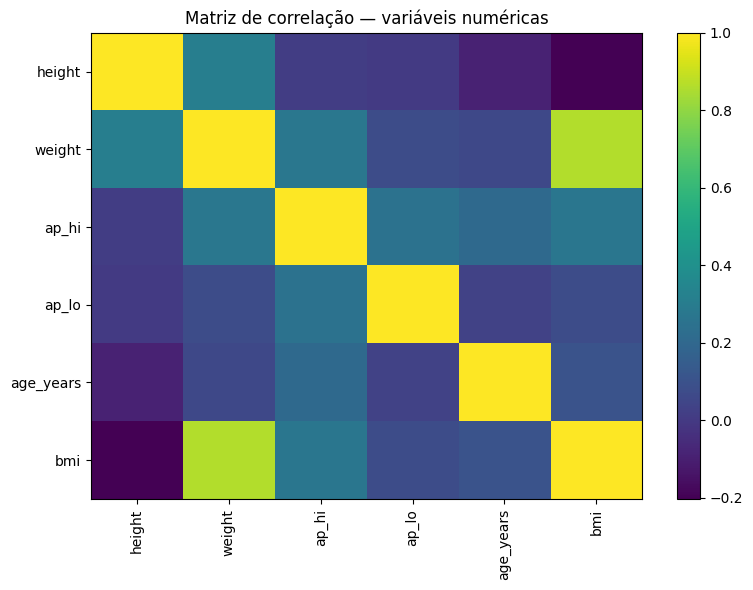

Top 8 |correlation| com o target:


,abs_corr
ap_hi,0.430431
age_years,0.238149
bmi,0.195059
weight,0.184297
ap_lo,0.111222
height,0.012180


In [35]:
# --- Correlação entre variáveis numéricas e relação com o TARGET ---
if len(NUM_COLS) > 0:
    num = df[NUM_COLS].copy()

    # matriz de correlação (Pearson)
    corr = num.corr(method="pearson")
    plt.figure(figsize=(8, 6))
    plt.title("Matriz de correlação — variáveis numéricas")
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(num.columns)), num.columns, rotation=90)
    plt.yticks(range(len(num.columns)), num.columns)
    plt.tight_layout()
    plt.show()

    # relação univariada com o target (numérico vs binário): |corr|
    tmp = num.join(df[TARGET])
    tc = tmp.corr(numeric_only=True)[TARGET].drop(TARGET).abs().sort_values(ascending=False)
    print("Top 8 |correlation| com o target:")
    display(tc.head(8).to_frame("abs_corr"))

else:
    print("Sem colunas numéricas em NUM_COLS para calcular correlação.")


In [36]:
# Convenções
assert TARGET == "cardio"

# --- NUMÉRICAS BASE (existentes no DF) ---
NUM_BASE = [
    "age_years", "ap_hi", "ap_lo", "height", "weight", "bmi", "pulse_pressure", "map_mean"
]
num_features = [c for c in NUM_BASE if c in df.columns]

# --- BINÁRIAS (0/1 no dataset) ---
BIN_BASE = ["smoke", "alco", "active", "gender"]
binary_features = [c for c in BIN_BASE if c in df.columns]

# --- ORDINAS (com ordem explícita) ---
ORD_BASE = ["cholesterol", "gluc", "age_group", "bmi_category"]
ordinal_features = [c for c in ORD_BASE if c in df.columns]

# Mapa de ordens por coluna (usamos este dicionário para construir ordinal_orders na ordem correta)
ORD_MAP = {
    "cholesterol": [1, 2, 3],
    "gluc": [1, 2, 3],
    "age_group": ["young", "adult", "senior", "elderly"],
    "bmi_category": ["underweight", "normal", "overweight", "obese"],
}

# ORDERS alinhado com a ordem exata de ordinal_features
ordinal_orders = [ORD_MAP[c] for c in ordinal_features]

# --- NOMINAIS (todas as categóricas sem ordem, excluindo as ordinais) ---
cat_all = df.select_dtypes(include=["category"]).columns.tolist()
nominal_features = [c for c in cat_all if c not in ordinal_features]

# ⚠️ Evitar overlaps: nenhuma categórica deve aparecer nas numéricas
num_features = [c for c in num_features if c not in (ordinal_features + nominal_features + binary_features)]

# Binárias: podes tratá-las como nominais (OneHot) ou deixá-las como numéricas (0/1).
# Para consistência com o pipeline, vamos tratá-las como NOMINAIS:
for c in binary_features:
    if c not in nominal_features:
        nominal_features.append(c)

# --- SANIDADE ---
miss_ord = [c for c in ordinal_features if c not in df.columns]
assert not miss_ord, f"Faltam colunas ordinais: {miss_ord}"
assert len(ordinal_orders) == len(ordinal_features), (
    f"ordinal_orders ({len(ordinal_orders)}) != ordinal_features ({len(ordinal_features)})"
)

# Relatório
print("num_features:", num_features)
print("binary_features (tratadas como nominais):", binary_features)
print("ordinal_features:", ordinal_features)
print("ordinal_orders (alinhadas):", ordinal_orders)
print("nominal_features:", nominal_features)

# Pequenos checks de coerência
intersections = {
    "num∩ord": set(num_features) & set(ordinal_features),
    "num∩nom": set(num_features) & set(nominal_features),
    "ord∩nom": set(ordinal_features) & set(nominal_features),
}
for k, v in intersections.items():
    assert len(v) == 0, f"Overlap inesperado em {k}: {sorted(v)}"


num_features: ['age_years', 'ap_hi', 'ap_lo', 'height', 'weight', 'bmi', 'pulse_pressure', 'map_mean']
binary_features (tratadas como nominais): ['smoke', 'alco', 'active', 'gender']
ordinal_features: ['cholesterol', 'gluc', 'age_group', 'bmi_category']
ordinal_orders (alinhadas): [[1, 2, 3], [1, 2, 3], ['young', 'adult', 'senior', 'elderly'], ['underweight', 'normal', 'overweight', 'obese']]
nominal_features: ['gender', 'smoke', 'alco', 'active']


In [38]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Numéricos: mediana + RobustScaler ---
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# --- Nominais (inclui binárias 0/1): moda + OneHot ---
# Compatibilidade entre versões do scikit-learn (sparse_output vs sparse)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe),
])

# --- Ordinais: moda + OrdinalEncoder com ordem explícita ---
ord_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(
        categories=ordinal_orders,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, nominal_features),   # inclui binárias
        ("ord", ord_pipe, ordinal_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor


,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [39]:

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Fit APENAS no treino (evita leakage)
X_train_proc = preprocessor.fit_transform(X_train, y_train)
X_test_proc  = preprocessor.transform(X_test)

# Nomes das features após o preprocessor
try:
    feat_names = preprocessor.get_feature_names_out()
except Exception:
    # fallback para versões antigas
    feat_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if hasattr(trans, "named_steps"):
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                base = cols if isinstance(cols, list) else [cols]
                try:
                    sub = last.get_feature_names_out(base)
                except Exception:
                    sub = base
                feat_names.extend(sub)
            else:
                base = cols if isinstance(cols, list) else [cols]
                feat_names.extend(base)
        else:
            base = cols if isinstance(cols, list) else [cols]
            feat_names.extend(base)

# Converter para DataFrame nomeado (útil para inspeção)
import pandas as pd
Xtr_df = pd.DataFrame(X_train_proc, columns=feat_names)
Xte_df = pd.DataFrame(X_test_proc,  columns=feat_names)

# Sanidade: shapes e estratificação preservada
print("Shapes:")
print(" - X_train:", X_train.shape, "->", Xtr_df.shape)
print(" - X_test :", X_test.shape,  "->", Xte_df.shape)

pos_train = y_train.mean()
pos_test  = y_test.mean()
print(f"Pos rate train: {pos_train:.3f} | test: {pos_test:.3f}")
assert abs(pos_train - pos_test) < 0.02, "Estratificação pode não ter sido preservada."

# Checks extra
assert Xtr_df.shape[1] == Xte_df.shape[1] > 0, "Número de features processadas inválido."
print("✅ Preprocessamento concluído e sem leakage.")

(X_train_proc.shape, X_test_proc.shape)



Shapes:
 - X_train: (56000, 16) -> (56000, 20)
 - X_test : (14000, 16) -> (14000, 20)
Pos rate train: 0.500 | test: 0.500
✅ Preprocessamento concluído e sem leakage.


((56000, 20), (14000, 20))

In [40]:
import joblib, numpy as np, json, time, os

PROC_PATH.mkdir(parents=True, exist_ok=True)

# Guardar pipeline
joblib.dump(preprocessor, PROC_PATH / "preprocessor.joblib")

# Converter para float32 para poupar espaço
np.save(PROC_PATH / "X_train.npy", X_train_proc.astype(np.float32))
np.save(PROC_PATH / "X_test.npy",  X_test_proc.astype(np.float32))

# Guardar targets
y_train.to_csv(PROC_PATH / "y_train.csv", index=False)
y_test.to_csv(PROC_PATH / "y_test.csv",  index=False)

# Manifesto com metadata
manifest = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "random_state": RANDOM_STATE,
    "n_train": int(len(y_train)),
    "n_test": int(len(y_test)),
    "n_features_raw": int(X.shape[1]),
    "n_features_processed": int(X_train_proc.shape[1]),
    "pos_rate_train": float(y_train.mean()),
    "pos_rate_test": float(y_test.mean()),
    "target": TARGET,
    "num_features": num_features,
    "ordinal_features": ordinal_features,
    "nominal_features": nominal_features,
}
with open(PROC_PATH / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

# Mostrar confirmação e tamanhos
def file_size_mb(path): 
    return round(os.path.getsize(path) / 1024**2, 2)

print("✅ Guardado em data/processed/:")
for fname in ["preprocessor.joblib", "X_train.npy", "X_test.npy", "y_train.csv", "y_test.csv", "manifest.json"]:
    path = PROC_PATH / fname
    if path.exists():
        print(f" - {fname:22s} {file_size_mb(path):>6} MB")


✅ Guardado em data/processed/:
 - preprocessor.joblib      0.01 MB
 - X_train.npy              4.27 MB
 - X_test.npy               1.07 MB
 - y_train.csv              0.16 MB
 - y_test.csv               0.04 MB
 - manifest.json             0.0 MB


In [41]:
import json

# Carregar arrays e targets
Xtr = np.load(PROC_PATH / "X_train.npy")
Xte = np.load(PROC_PATH / "X_test.npy")
ytr = pd.read_csv(PROC_PATH / "y_train.csv")
yte = pd.read_csv(PROC_PATH / "y_test.csv")

print("X_train:", Xtr.shape, " X_test:", Xte.shape)
print("y_train:", ytr.shape, " y_test:", yte.shape)

# Taxa de positivos
print("\nTrain pos rate:", ytr[TARGET].mean().round(3), " | Test pos rate:", yte[TARGET].mean().round(3))

# Verificar consistência com shapes originais (se X_train_proc/X_test_proc ainda existem no kernel)
try:
    assert Xtr.shape == X_train_proc.shape and Xte.shape == X_test_proc.shape, "Shapes carregados ≠ shapes em memória."
    print("✅ Shapes carregados coincidem com os processados na sessão.")
except NameError:
    print("ℹ️ Shapes em memória não estão disponíveis (nova sessão).")

# Guardar nomes de features processadas (se ainda não guardaste)
feat_names_path = PROC_PATH / "feature_names.json"
if not feat_names_path.exists():
    try:
        feat_names = preprocessor.get_feature_names_out().tolist()
    except Exception:
        # fallback simples: usa nomes aproximados (menos robusto)
        feat_names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == "remainder":
                continue
            base = cols if isinstance(cols, list) else [cols]
            feat_names.extend([str(x) for x in base])
    with open(feat_names_path, "w") as f:
        json.dump(feat_names, f, indent=2)
    print(f"💾 feature_names.json guardado com {len(feat_names)} nomes.")

# Verificar manifesto (se existir)
manifest_path = PROC_PATH / "manifest.json"
if manifest_path.exists():
    with open(manifest_path) as f:
        manifest = json.load(f)
    ok_feats = (manifest.get("n_features_processed") == int(Xtr.shape[1]) == int(Xte.shape[1]))
    ok_rows  = (manifest.get("n_train") == int(len(ytr))) and (manifest.get("n_test") == int(len(yte)))
    print("\nManifest checks:")
    print(" - n_features_processed ok? ", ok_feats)
    print(" - n_train/n_test ok?       ", ok_rows)
    if not ok_feats or not ok_rows:
        print("⚠️ Diferença entre manifest e artefactos — considera regenerar artefactos.")

# Checks finais
assert Xtr.shape[1] == Xte.shape[1] > 0, "Número de features inconsistente ou zero."
assert ytr[TARGET].isin([0,1]).all() and yte[TARGET].isin([0,1]).all(), "Targets não binários após carregamento."
print("✅ Verificações finais concluídas.")


X_train: (56000, 20)  X_test: (14000, 20)
y_train: (56000, 1)  y_test: (14000, 1)

Train pos rate: 0.5  | Test pos rate: 0.5
✅ Shapes carregados coincidem com os processados na sessão.
💾 feature_names.json guardado com 20 nomes.

Manifest checks:
 - n_features_processed ok?  True
 - n_train/n_test ok?        True
✅ Verificações finais concluídas.


In [42]:
import numpy as np

print("Shapes:")
print(" - X_train:", X_train_proc.shape)
print(" - X_test :", X_test_proc.shape)
print(f"Train pos rate: {y_train.mean():.3f} | Test pos rate: {y_test.mean():.3f}")

# Verificação da consistência do nº de features (usando fit completo apenas para validação)
print("\nVerificando consistência do pipeline completo (fit em todo o dataset)...")
X_full_proc = preprocessor.fit(X, y).transform(X)

n_train, n_test, n_full = X_train_proc.shape[1], X_test_proc.shape[1], X_full_proc.shape[1]
assert n_train == n_test == n_full, (
    f"Nº de features inconsistente! Train={n_train}, Test={n_test}, Full={n_full}"
)
print(f"✅ Nº de features consistente: {n_full}")

# Sanidade extra: sem NaN após transformação
assert not np.isnan(X_full_proc).any(), "Há NaNs após o preprocessor!"
print("✅ Nenhum NaN encontrado após transformação.")

print("\n🔍 Verificação final do preprocessor concluída com sucesso.")

Shapes:
 - X_train: (56000, 20)
 - X_test : (14000, 20)
Train pos rate: 0.500 | Test pos rate: 0.500

Verificando consistência do pipeline completo (fit em todo o dataset)...
✅ Nº de features consistente: 20
✅ Nenhum NaN encontrado após transformação.

🔍 Verificação final do preprocessor concluída com sucesso.


## Conclusões e Próximos Passos

### ✅ Resultados Obtidos

1. **Dataset Preparado com Sucesso:**
   - ✅ 70.000 registos limpos e validados
   - ✅ 16 features após transformação
   - ✅ Classes perfeitamente balanceadas (50/50)
   - ✅ Train/test split estratificado (80/20)

2. **Pipeline Robusta Implementada:**
   - ✅ Tratamento diferenciado por tipo de feature
   - ✅ Preprocessamento reprodutível
   - ✅ Validação de consistência
   - ✅ Dados exportados em formatos otimizados

3. **Feature Engineering Eficaz:**
   - ✅ BMI calculado corretamente
   - ✅ Pulse pressure e MAP adicionados
   - ✅ Grupos etários e categorias BMI criados
   - ✅ Variáveis ordinais preservadas com ordem

### 🚀 Dataset Pronto para Modelação

O dataset está agora completamente preparado para a fase de modelação:
- **Ficheiros exportados:** `X_train.npy`, `X_test.npy`, `y_train.csv`, `y_test.csv`
- **Pipeline salva:** `preprocessor.joblib`
- **Formato otimizado:** Arrays NumPy para features, CSV para targets

### 📈 Próximos Passos (M2)

1. **Experimentação com Modelos:**
   - Logistic Regression (baseline)
   - Random Forest
   - Gradient Boosting
   - SVM

2. **Validação e Tuning:**
   - Cross-validation
   - Hyperparameter tuning
   - Feature importance analysis

3. **Avaliação:**
   - Métricas de classificação
   - Análise de erros
   - Interpretabilidade do modelo

---
🏁 **Assignment M1 completo com sucesso!**